In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs, expm_multiply
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import time
import numba
from numba import jit
# from optimparallel import minimize_parallel

In [2]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [3]:
L = 2
Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 2*int(format(j, '0{}b'.format(L))[i])-1
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 2*int(format(j, '0{}b'.format(L))[i])-1 
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

C:\Users\nfber\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


# Exact time evolution

In [4]:
H = sum([Heis[i][(i+1)%L] for i in range(L)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}
# Hzzz = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) + sum([diags(Heis[i][(i+3)%L].diagonal()) for i in range(L)])) / 4
# e, v = eigs(H, 30)

# ind = e.argsort()
# e = e[idx]
# v = v[:, idx]
# np.conj(v.T) @ H @ v - np.diag(e), decimals=3)

In [5]:
H.toarray()

array([[ 0.5,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  1. ,  0. ],
       [ 0. ,  1. , -0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0.5]])

In [6]:
tf = 25
dt = tf / 200
Nt = int(tf / dt)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c-1]
init = UnitVector(int(''.join(c), 2))

In [7]:
revos = [np.zeros(2**L) for i in range(Nt+1)]
revos[0] = init
for i in range(Nt):
    # scipy.sparse.linalg.expm_multiply
    revos[i+1] = expm(-1j * H * dt) @ revos[i]

In [8]:
Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ (Sz[0]) @ revos[i] / 2)

C:\Users\nfber\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


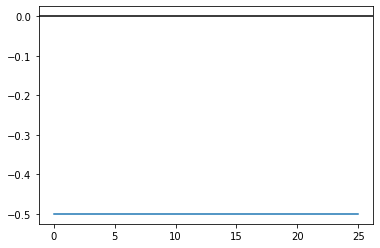

In [9]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

# Trotter Evolution

In [10]:
def TrotterEvolve(tf, nt, init):
    dt = tf / nt
    UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L, 2)]) / 4) # since Python indices start at 0, this is actually even
    UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4) # since Python indices start at 0, this is actually the odd indices
    # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
    # UTrotter = UEven @ UOdd @ UZ
    UTrotter = UEven @ UOdd # ueven @ ubdy @ uodd <- only for odd L
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

In [25]:
def get_angles(a):
    return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)
get_angles(np.pi/4)

(0.0, 0.0, 0.0)

In [24]:
expm(-1j * np.pi * Heis[0][(0+1)%L] / 4) @ init

array([0.70710678-0.70710678j, 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ])

In [44]:
TrotterFixStepList = [init]
for i in range(Nt):
    TrotterFixStepList.append(TrotterEvolve((i+1)*dt, 1, init))
TrotterFixStepSz = []
for i in range(len(TrotterFixStepList)):
    TrotterFixStepSz.append(np.conj(TrotterFixStepList[i]) @ Sz[0] @ TrotterFixStepList[i] / 2)

In [57]:
 for i in range(0, L, 2):
     print(i)
print()
 for i in range(1, L, 2):
     print(i)

0

1


In [15]:
TrotterEvolve(-np.pi/2, 1, init)

array([ 0. +0.j , -0.5+0.j ,  0. +0.5j,  0. +0.j ,  0.5+0.j ,  0. +0.j ,
        0. +0.j ,  0. +0.j ,  0. +0.5j,  0. +0.j ,  0. +0.j ,  0. +0.j ,
        0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ])

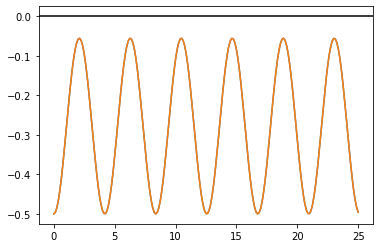

In [38]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
plt.axhline(y=0, color='k')

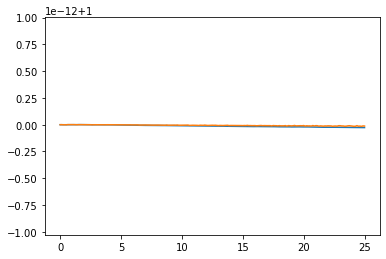

In [36]:
ExFidelity = [abs(np.conj(revos[i]) @ revos[i])**2 for i in range(len(revos))]
VTDFidelity = [abs(np.conj(revos[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]
plt.plot([i*dt for i in range(len(revos))], ExFidelity)
plt.plot([i*dt for i in range(len(TrotterFixStepList))], VTDFidelity)

# Ansatz

In [115]:
p = 1
def Ansatz(params):
    # check for correct length of params
    psi_ansz = init
    for i in range(p): # len(params) // L
        for j in range(0, L, 2):
            # odd first, then even. Apply to left
            psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L], psi_ansz)
            # psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        for j in range(1, L, 2):
            psi_ansz = expm_multiply(-1j * params[(L*i)+j] * Heis[j][(j+1)%L], psi_ansz)
            # psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        # for j in range(L):
        #     psi_ansz = expm(-1j * params[(2*L*i)+L+j] * diags(Heis[j][(j+2)%L].diagonal()).tocsc()) @ psi_ansz
    return psi_ansz

def Loss(x, target, O):
    psi_ansz = Ansatz(x)
    Sz_ansz = np.conj(psi_ansz) @ (O) @ psi_ansz / 2
    Sz_ex = np.conj(target) @ (O) @ target / 2
    return abs(Sz_ansz - Sz_ex)

def Fidelity(x, target):
    psi_ansz = Ansatz(x)
    return 1 - abs(np.conj(target) @ psi_ansz)**2

In [11]:
# VarSzList = []
# params = []
# params.append(np.random.uniform(0, 2*np.pi, L*p))
# for i in range(1, len(revos)+1):
#     sol = minimize(fun=Loss, x0=params[i-1], args=(revos[i-1], Sz[0]-Sz[1]+Sz[2]-Sz[3]), method='SLSQP')
#     params.append(sol.x)
#     bar = Ansatz(sol.x)
#     VarSzList.append(np.conj(bar) @ Sz[0] @ bar / 2)

#     if (i % 10 == 0):
#         print(i)

In [12]:
# plt.plot([i*dt for i in range(len(revos))], Szt, label='Exact')
# # plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
# plt.plot([i*dt for i in range(len(VarSzList))], VarSzList, label='Ansatz p=1')
# plt.legend()
# plt.axhline(y=0, color='k')

In [17]:
init_params = np.random.uniform(0, np.pi, L*p)
O = Sz[0]-Sz[1]+Sz[2]-Sz[3]
ind = 4
start = time.time()
# sol = minimize(fun=Loss, x0=init_params, args=(revos[ind], O), method='L-BFGS-B')
sol = minimize(fun=Fidelity, x0=init_params, args=(revos[ind]), method='L-BFGS-B')

# sol = minimize_parallel(fun=Loss, x0=init_params, args=revos[-1], parallel={'loginfo': True})
end = time.time()
print(end - start)
print(sol)
print(repr(sol.x))

13.572630643844604
      fun: 0.047299474150480636
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.22124533e-06, -4.55191443e-06, -1.33226764e-07, -4.41868766e-06,
       -6.69464484e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 168
      nit: 15
     njev: 28
   status: 0
  success: True
        x: array([0.21476252, 1.79828598, 2.93908549, 1.83515746, 0.21690803])
array([0.21476252, 1.79828598, 2.93908549, 1.83515746, 0.21690803])


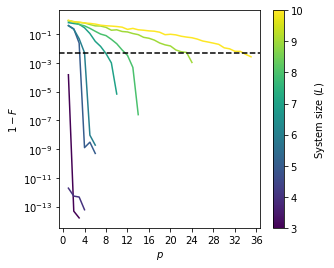

In [39]:
Ls = [[0.00015256013855469153, 4.907185768843192e-14, 1.6653345369377348e-14],
     [1.9617640845126516e-12, 5.488942633746774e-13, 4.731770530952417e-13, 6.17284001691587e-14],
     [0.4069000826479028, 0.2378422486937437, 0.024432551902840216, 1.2919141312295324e-09, 3.09800118891701e-09, 5.107769762702219e-10],   
     [0.38881245977091017, 0.22441976450186074, 0.048631739642732597, 0.005182203313955247, 9.50861900328448e-09, 1.938797122846836e-09],
     [0.6420723646096741, 0.5581311119772459, 0.49642477754337, 0.28066697161920773, 0.11249692395611921, 0.03206784416958486, 0.014203238148108088, 0.004506900547840642, 0.001017898445123011, 6.9348354840848e-06],
     [0.8536958935049996, 0.6951962430165066, 0.47586992138471884, 0.3839291931612888, 0.2575741172041175, 0.16072210325517322, 0.1026678294111073, 0.08052865923892405, 0.044014624424270066, 0.02191650807403589, 0.008091574986286099, 0.003400593223235715, 0.0004924362611831157, 2.5471446374325524e-07],
     [0.8866691981842769, 0.760753491939057, 0.6625248401365769, 0.6102880295004625, 0.47729626339520637, 0.3827278600560313, 0.37230409291758537, 0.30188770472967374, 0.190332885237388, 0.20401394705587317, 0.15565227583236574, 0.1447443654262024, 0.11222565455568434, 0.09405244808558377, 0.06116219271492718, 0.05272844523140208, 0.03907490973475258, 0.024556549441910436, 0.018283234804949422, 0.015293679383350245, 0.008092329127764475, 0.006049630973728015, 0.0053908322568935185, 0.0010907864945521872],
    [0.9426517468140033, 0.7244126867495322, 0.6974415994408958, 0.6062960511586379, 0.5691913910361596, 0.5109344121029846, 0.42631620725268093, 0.38976093678595625, 0.369959825571331, 0.3447797465481668, 0.31092188682942234, 0.21824148994223347, 0.2560686223464963, 0.20417848911893732, 0.19018201597739404, 0.17182434551659265, 0.1627302074781476, 0.1378764683010003, 0.09303816846587709, 0.09985435346722071, 0.09052607504582355, 0.0728638280347007, 0.06344530436679552, 0.057140318877740515, 0.046006302125094045, 0.03386866085474993, 0.02878055288107284, 0.024026041938206122, 0.019746754157732305, 0.011368252596775985, 0.009727624112058186, 0.00652378474558335, 0.006433283011375468, 0.0040112154073908, 0.0027049602685794705]
 ]
# L10 = [0.6369274620479408, 0.5224910459936618, 0.4797445893373805, 0.3436969438668106, 0.2975110350752568, 0.28952671496855387, 0.25106137841898446]
# L11 = [0.7884947125456306, 0.6862101064288398, 0.5347413862950722]

fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

color = matplotlib.cm.viridis
c = np.arange(3, 3 + len(Ls))
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=color)
cmap.set_array([])

ax.set_prop_cycle('color',[color(i) for i in np.linspace(0, 1, len(Ls))])

for i in range(len(Ls)):
    plt.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i], label=f"L={i+3}")

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

cbar = plt.colorbar(cmap, ticks=c)
cbar.set_label('System size $(L)$')
cbar.ax.get_yaxis().labelpad = 10

plt.axhline(5e-3, color='k', linestyle='--')
plt.ylabel('$1-F$')
# plt.title('$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
# plt.ylabel('$1 - | \langle \psi (t) | \Phi_p(\\vartheta) \\rangle |$')
plt.xlabel('$p$')
plt.yscale('log')
plt.savefig('figures/p_vs_fidelity', dpi=300, transparent=False, bbox_inches='tight')


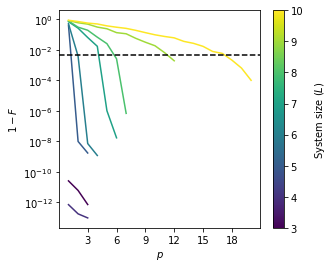

In [38]:
Ls = [[2.599098714028969e-11, 6.125322471461914e-12, 7.327471962526033e-13],
     [7.192024753521764e-13, 1.787459069646502e-13, 9.681144774731365e-14],
     [0.4159596154146591, 9.986991234001152e-09, 1.7478323233177662e-09],
     [0.5234665493958477, 0.0038686775787357686, 7.284267189433535e-09, 1.2007779215394976e-09],
     [0.7142353613878716, 0.26846378568707496, 0.06547833763979549, 0.0173487490934342, 1.0313857635724233e-06, 1.7326521217775337e-08],
     [0.7835836381520376, 0.3121972984683157, 0.19619100202187645, 0.06887489564775928, 0.02583280676792732, 0.0026438715287678827, 6.952103905888407e-07],
     [0.8483904959898904, 0.6072931714019811, 0.4941812451313077, 0.31591013845472105, 0.24532187694141727, 0.13663638552074864, 0.11536215694501595, 0.05786562167742082, 0.032166035913461566, 0.018880427639350827, 0.006625673250153397, 0.001948521023840355], 
     [0.8879790111695847, 0.7294990436175095, 0.5790671880011762, 0.5063480404801541, 0.37952179032163, 0.30989802077110384, 0.26024103836429746, 0.19308785259896655, 0.13654299672655845, 0.09858994902173868, 0.07661753719910824, 0.06219268687705359, 0.03649838013077711, 0.02721716350336234, 0.017231557090538474, 0.007947747273803318, 0.005933570212399042, 0.002158684827835433, 0.0006483295091939123, 0.00010185335759260727]]

fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

color = matplotlib.cm.viridis
c = np.arange(3, 3 + len(Ls))
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=color)
cmap.set_array([])

ax.set_prop_cycle('color',[color(i) for i in np.linspace(0, 1, len(Ls))])

for i in range(len(Ls)):
    plt.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i], label=f"L={i+3}")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


cbar = plt.colorbar(cmap, ticks=c)
cbar.set_label('System size $(L)$')
cbar.ax.get_yaxis().labelpad = 10

plt.axhline(5e-3, color='k', linestyle='--')
# plt.title('$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j + \sum_i \sigma_i^z \sigma_{i+2}^z $')
plt.ylabel('$1-F$')
# plt.ylabel('$1 - | \langle \psi (t) | \Phi_p(\\vartheta) \\rangle |$')
plt.xlabel('$p$')
# plt.grid(True)
# plt.legend(loc='lower right')
plt.yscale('log')

# plt.xlim([0,11])
plt.savefig('figures/p_vs_fidelityHz', dpi=300, transparent=False, bbox_inches='tight')


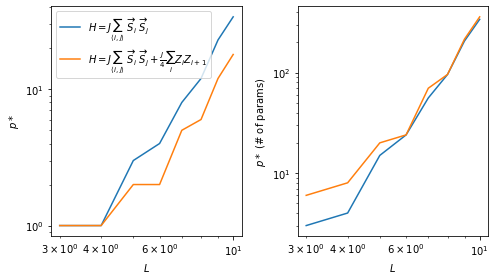

In [46]:

LstarH = np.array([1, 1, 3, 4, 8, 12, 23, 34])
L = np.array([3, 4, 5, 6, 7, 8, 9, 10])
LstarHparams = np.multiply(LstarH, L)
LHz = np.array([3, 4, 5, 6, 7, 8, 9, 10])
LstarHz = np.array([1, 1, 2, 2, 5, 6, 12, 18])
LstarHzparams = np.multiply(LstarHz*2, LHz)
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].set(ylabel='$p*$', xlabel='$L$')
# ax[0].title('L vs p* for Heisenberg models')
ax[0].loglog(L, LstarH, label='$H = J\sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
ax[0].loglog(LHz, LstarHz, label='$H = J\sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j + \\frac{J}{4}\sum_i Z_i Z_{i+1}$')
ax[1].loglog(L, LstarHparams)
ax[1].loglog(LHz, LstarHzparams)
ax[1].set(ylabel='$p*$ (# of params)', xlabel='$L$')

ax[0].legend(loc='upper left')
fig.tight_layout()

# plt.savefig('L_vs_pstar', dpi=300, transparent=False, bbox_inches='tight')
